[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)


# Customer Feedback Chatbot: Filtering and Trimming Messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

This chatbot serves as a **customer feedback assistant** that:
- Keeps only the **last three messages** when interacting with users
- Trims older messages to ensure faster responses and reduced token usage
- Maintains conversation continuity while optimizing performance
- Uses Mistral AI for efficient feedback collection

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain langchain_core langchain_mistralai tiktoken

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY") 
_set_env("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "customer-feedback-chatbot"



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage("Thank you for contacting us! How can we assist with your feedback?", name="Bot")]
messages.append(HumanMessage("I wanted to share my experience with your service.", name="Customer"))

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

Thank you for contacting us! How can we assist with your feedback?
================================ Human Message =================================
Name: Customer

I wanted to share my experience with your service.


In [3]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="mistral-small-latest", temperature=0.5)


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `customer-feedback-chatbot`. 


## Messages as state

First, let's define some messages for our customer feedback chatbot.


Recall we can pass them to a chat model.


We can run our chat model in a simple graph with `MessagesState`.


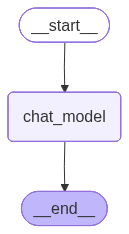

================================== Ai Message ==================================
Name: Bot

Thank you for contacting us! How can we assist with your feedback?
================================ Human Message =================================
Name: Customer

I wanted to share my experience with your service.
================================== Ai Message ==================================

We're glad you reached out! We'd love to hear about your experience with our service. Please share the details, and we'll do our best to address any concerns or celebrate your positive feedback. Your input helps us improve and serve you better.

You can share your experience here, and we'll respond as soon as possible.


In [4]:
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()


## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.


In [ ]:
from langchain_core.messages import RemoveMessage

def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]  # keep last 2
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

messages = [
    AIMessage("Thank you for contacting us! How can we help?", name="Bot", id="1"),
    HumanMessage("I have feedback about your product.", name="Customer", id="2"),
    AIMessage("We'd love to hear it! Please share your thoughts.", name="Bot", id="3"),
    HumanMessage("The interface is great, but the loading time is slow.", name="Customer", id="4")
]

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

We'd love to hear it! Please share your thoughts.
================================ Human Message =================================
Name: Customer

The interface is great, but the loading time is slow.
================================== Ai Message ==================================

Thank you for your feedback! We're glad you like the interface, and we appreciate you bringing up the loading time. We're constantly working to improve performance, and your input helps us prioritize our efforts.

To help us better understand the issue, could you share a bit more detail?
- Are you experiencing slow loading on specific pages or features?
- What device and browser are you using?
- Is the slowdown consistent, or does it happen intermittently?

This information will help us diagnose and address the issue more effectively. Thanks again for your patience and support!


## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.


In [ ]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

messages.append(output['messages'][-1])
messages.append(HumanMessage("Can you improve that?", name="Customer"))

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

Thank you for contacting us! How can we help?
================================ Human Message =================================
Name: Customer

I have feedback about your product.
================================== Ai Message ==================================
Name: Bot

We'd love to hear it! Please share your thoughts.
================================ Human Message =================================
Name: Customer

The interface is great, but the loading time is slow.
================================== Ai Message ==================================

Thank you for your feedback! We're glad you like the interface, and we appreciate you bringing up the loading time. We're constantly working to improve performance, and your input helps us prioritize our efforts.

To help us better understand the issue, could you share a bit more detail?
- Are you experiencing slow loading on specific pages or features

Let's take our existing list of messages, append the above LLM response, and append a follow-up question from the customer.


The state has all of the messages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message.

Check your LangSmith project "customer-feedback-chatbot" to view the trace!


## Trim messages

Another approach is to trim messages based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.


## CUSTOMER FEEDBACK CHATBOT TWEAKS

**Key Optimization**: This customer feedback chatbot keeps only the **last three messages** when interacting with users, ensuring:
- Faster response times
- Reduced token usage and costs
- Maintained conversation continuity

The trimming strategy balances context awareness with performance efficiency.


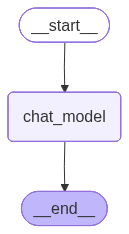

In [ ]:
def chat_model_node(state: MessagesState):
    """
    Process customer feedback by passing only the last 3 messages to the LLM.
    This maintains conversation continuity while optimizing token usage.
    """
    last_n = 3 
    messages_to_send = state["messages"][-last_n:]
    
    return {"messages": [llm.invoke(messages_to_send)]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


Now let's test the customer feedback chatbot with multiple interactions to show how it maintains context with only the last 3 messages.


In [ ]:
feedback_messages = [
    AIMessage("Welcome to Customer Feedback! We'd love to hear your thoughts.", name="Bot", id="1"),
    HumanMessage("Your product is great, but I have some suggestions.", name="Customer", id="2"),
    AIMessage("Please tell us your suggestions - we value your input!", name="Bot", id="3"),
    HumanMessage("First, the onboarding process could be simpler.", name="Customer", id="4"),
]

output = graph.invoke({'messages': feedback_messages})
print("\n=== Customer Feedback Chatbot Response ===\n")
for m in output['messages'][-1:]:
    m.pretty_print()



=== Customer Feedback Chatbot Response ===

================================== Ai Message ==================================

Thank you for your feedback! Simplifying the onboarding process is a great suggestion. Could you share more details about what you found challenging or time-consuming? For example:

- Was the sign-up flow too long?
- Were there unclear instructions or steps?
- Did you encounter technical issues?

Your insights will help us make improvements. We appreciate your help in making the experience smoother for everyone! 😊


In [ ]:
feedback_messages.append(output['messages'][-1])
feedback_messages.append(HumanMessage("Also, the documentation is unclear in places.", name="Customer"))

output = graph.invoke({'messages': feedback_messages})
print("\n=== Follow-up Feedback Response ===\n")
for m in output['messages'][-1:]:
    m.pretty_print()



=== Follow-up Feedback Response ===

================================== Ai Message ==================================

Thank you for pointing that out! Clear and helpful documentation is crucial, and we appreciate your feedback. Could you share more details about which parts were unclear or confusing? For example:

- Were there specific sections, terms, or steps that lacked clarity?
- Did you struggle to find answers to common questions?
- Were there any missing examples or explanations?

Your feedback will help us improve the documentation so it’s more intuitive and user-friendly. If you’d like, you can also share suggestions on how we could make it better. Thanks again for your input! 😊


In [ ]:
feedback_messages.append(output['messages'][-1])
feedback_messages.append(HumanMessage("Can you address these points in the next update?", name="Customer"))

output = graph.invoke({'messages': feedback_messages})
print("\n=== Final Response ===\n")
for m in output['messages'][-1:]:
    m.pretty_print()



=== Final Response ===

================================== Ai Message ==================================

Absolutely! I’ll make sure to address these points in the next update. Here’s how I’ll handle it:

1. **Clarify Unclear Sections** – I’ll review the documentation to identify and improve any ambiguous or confusing parts, ensuring explanations are precise and easy to follow.
2. **Add Missing Examples** – If certain concepts lacked practical examples, I’ll include them to make the content more actionable.
3. **Improve Navigation & Searchability** – I’ll ensure key information is well-organized and easy to find, possibly adding a table of contents or better indexing.
4. **Gather Feedback** – I’ll take note of your specific concerns and incorporate them into the revisions.

Would you like to share more details about the exact sections or topics that need improvement? That way, I can prioritize them in the update. Thanks for helping us make the documentation better! 🚀
